## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [0]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 15, 20, 25]

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
# Define results
results = {}
for patience in PATIENCE :


    # 如'acc','val_acc','loss'和'val_loss'等等。
    earlystop = EarlyStopping(monitor = "val_acc",    # 試改變 monitor "Validation Accuracy" 並比較結果
                              patience = patience,    # 調整 earlystop 的等待次數至 10, 25 並比較結果
                              verbose=1
                              )


    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    # plot
    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

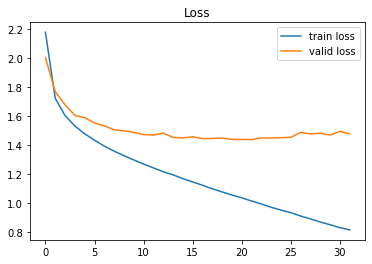
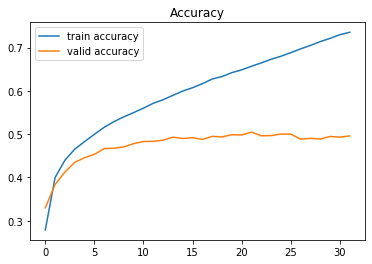

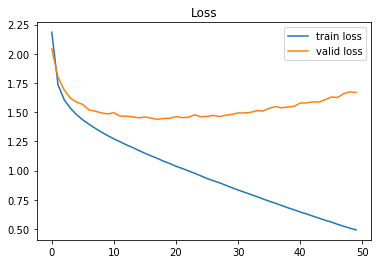
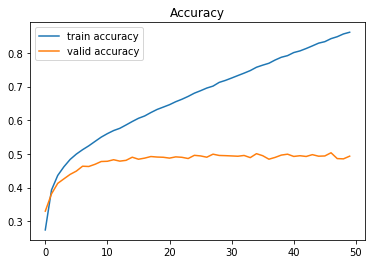

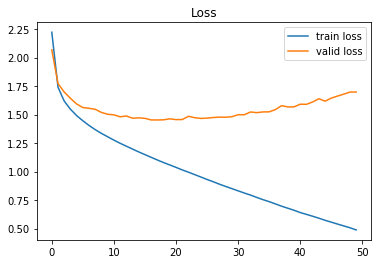
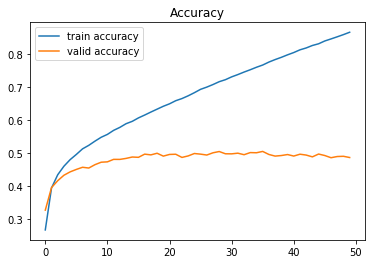

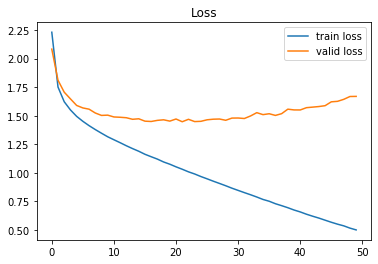
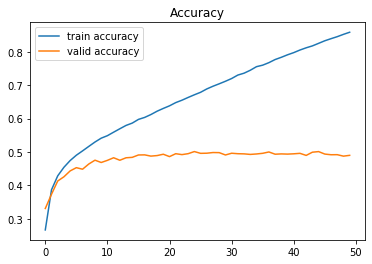

# 為何要使用 EarlyStopping：繼續訓練會導致測試集準確率下降。
過度擬合

學習率過大導致不收斂

使用 Regulizers 時，Loss 減少未必是準確率上升，可能是 weights 變少而已。

EarlyStopping 可以監控的項目
acc, val_acc, loss, val_loss, ...etc 等 loss 與 metrics

有時候要監控的項目不是越小越好 (“min”)，這時候要可以手動將 mode 設成 “max”

--

EarlyStopping是什麼
EarlyStopping是Callbacks的一種，callbacks用於指定在每個epoch開始和結束的時候進行哪種特定操作。Callbacks中有一些設置好的接口，可以直接使用，如'acc','val_acc','loss'和'val_loss'等等。

為什麼要用EarlyStopping
根本原因就是因為繼續訓練會導致測試集上的準確率下降。

那繼續訓練導致測試準確率下降的原因猜測可能是

1.過擬合

2.學習率過大導致不收斂

3.使用正則項的時候，Loss的減少可能不是因為準確率增加導致的，而是因為權重大小的降低。

當然使用EarlyStopping也可以加快學習的速度，提高調參效率。

EarlyStopping的使用與技巧
一般是在model.fit函數中調用callbacks，fit函數中有一個參數為callbacks。注意這裡需要輸入的是list類型的數據，所以通常情況只用EarlyStopping的話也要是[EarlyStopping()]

EarlyStopping的參數有¶
monitor: 監控的數據接口，有'acc','val_acc','loss','val_loss'等等。
正常情況下如果有驗證集，就用'val_acc'或者'val_loss'。